In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
plt.rcParams['font.size'] = 14
#import pylab_util as PU
import os

In [2]:
import control
#import digcomp

In [3]:
import serial
import serial_utils

In [4]:
portname = '/dev/cu.usbmodem1421'

In [6]:
serial.VERSION.split('.')

['3', '1', '1']

In [411]:
def read_all(ser):
    out = []
    while ser.in_waiting > 0:
        data1b = ser.read(1)
        data1 = data1b.decode('utf-8')
        out.append(data1)
        
    outstr = ''.join(out)
    return outstr

In [412]:
def print_all(ser):
    out = read_all(ser)
    print(out)

In [413]:
def write_char(charin):
    myint = ord(charin)
    serial_utils.WriteByte(ser, myint)

In [414]:
def write_string(string_in):
    for mychar in string_in:
        write_char(mychar)

In [415]:
def write_int(int_in):
    int_str = '%i' % int_in
    write_string(int_str)

In [416]:
def write_float(float_in):
    float_str = '%0.4f' % float_in
    write_string(float_str)

In [417]:
ser = serial.Serial(portname, 115200, timeout=1)
debug_line = serial_utils.Read_Line(ser)
line_str = ''.join(debug_line)
line_str

'DC Motor MPU 6050input s to start a test, z to zero'

In [418]:
print_all(ser)

In [419]:
ser.flushInput()
ser.flushOutput()

In [420]:
def get_data():
    data = ''
    i = 0
    num_empty = 0
    
    while i < 100:
        new_data = read_all(ser)
        data += new_data
        time.sleep(0.2)
        i += 1
        test_str = new_data.strip()
        if not test_str:
            num_empty += 1
        else:
            num_empty = 0
        
        if num_empty > 5:
            break
            
    return data

In [421]:
def data_to_float_array(data):
    mylist = data.split('\n')
    clean_list = mylist#[3:]
    clean_2 = list(filter(None,clean_list))
    
    
    end_ind = None
    
    for i, row in enumerate(clean_2):
        if row.find("input") > -1:
            end_ind = i
            
    clean_3 = clean_2[0:end_ind]
    nested_list = [row.split(',') for row in clean_3]
    str_array = np.array(nested_list)
    float_array = str_array.astype(float)
    return float_array
    #return str_array

In [422]:
class data_plotter_6050(object):
    def __init__(self, data):
        """save the columns of data to various attrs"""
        float_array = data_to_float_array(data)
        self.n = float_array[:,0]
        self.t_ms = float_array[:,1]
        self.t = self.t_ms/1000
        self.dt = self.t[1:] - self.t[0:-1]
        self.float_array = float_array
        
        self.thd = float_array[:,2]
        self.enc = float_array[:,3]
        
        #self.pwm1 = float_array[:,4]
        #self.pwm2 = float_array[:,5]
        #self.enc1 = float_array[:,6]
        #self.enc2 = float_array[:,7]
        ###theta1 = float_array[:,-3]
        ###theta2 = float_array[:,-2]
        #self.sonardiff = float_array[:,-4]
        #self.dt2 = float_array[:,-3]
        #self.d2 = float_array[:,-5]
        #self.d1 = float_array[:,-6]
        #self.filt_sonar = float_array[:,-2]
        #self.mpu_comp_filt = float_array[:,-1]
        
        
        
    def _plot(self, attr_list, title=None, legend=True, legloc=1):
        plt.figure()
        
        for attr in attr_list:
            vect = getattr(self, attr)
            plt.plot(self.t, vect, label=attr)
            
        if legend:
            plt.legend(loc=legloc)
            
        if title:
            plt.title(title)
        
    def dt_plot(self):
        plt.figure()
        plt.plot(self.t[1:],self.dt)
        plt.title('dt check')
        
    def encoder_plot(self):
        #self._plot(['enc1','enc2'],title='Encoder Comp')
        plt.figure()
        plt.plot(self.t,self.enc1, self.t, -self.enc2)
        plt.legend(['enc1','-enc2'],loc=5)
        ratio = self.enc1[-1]/-self.enc2[-1]
        print('end ratio: %0.4g' % ratio)
        
        
    def data_check(self):
        nr, nc = self.float_array.shape
        
        for i in range(nc):
            plt.figure()
            plt.plot(self.t, self.float_array[:,i])
            plt.title("i = %i" % i)
        
    
    def string_from_float_array(self):
        """Convert float_array back into a string for saving the data"""
        delim = ','
        str_array = self.float_array.astype(str)
        row_list = []
        for row in str_array:
            row_str = delim.join(row)
            row_list.append(row_str)
            
        data_str = '\n'.join(row_list)
        return data_str
    
    
    def save_data(self, pat="test_%0.2i_MPU_6050.csv"):
        # find the first test filename that does not
        # exist
        filename = None
        for i in range(1,200):
            fn = pat % i
            if not os.path.exists(fn):
                filename = fn
                break
                
        data_str = self.string_from_float_array()
        
        assert filename is not None, "did not find a valid filename"
        f = open(filename,'w')
        f.write(data_str)
        f.close()
        return filename
            
    def main(self):
        self.dt_plot()
        #self._plot(['d1','d2'], title='Raw Sonar Output')
        #self._plot(['sonardiff','filt_sonar'], title='Sonar Diff.', legend=False)
        #self._plot(['mpu_comp_filt'],title='MPU Comp. Filt.', legend=False)
        #self._plot(['pwm2'],title='PWM 2 = Speed', legend=False)
        self._plot(['thd','enc'],title='$\\theta_d$ and $\\theta_a$', legend=False)
        self.data_check()

In [423]:
write_char("s")
time.sleep(0.1)
data = get_data()

In [424]:
print(data)

1,0.04,0,0,0,-35.49,832.00,16844.00,-2.83,-286.00
2,4.97,0,0,0,-34.54,1060.00,16920.00,-3.58,-271.00
3,9.89,0,0,0,-33.63,1088.00,16924.00,-3.68,-273.00
4,14.82,0,0,0,-32.72,932.00,16940.00,-3.15,-279.00
5,19.76,0,0,0,-31.83,748.00,17040.00,-2.51,-293.00
6,24.68,0,0,0,-30.97,868.00,16844.00,-2.95,-305.00
7,29.62,0,0,0,-30.17,1136.00,16908.00,-3.84,-297.00
8,34.54,0,0,0,-29.40,1200.00,16576.00,-4.14,-267.00
9,39.46,0,0,0,-28.61,808.00,16832.00,-2.75,-264.00
10,44.39,0,0,0,-27.83,684.00,16956.00,-2.31,-292.00
11,49.32,0,0,0,-27.10,880.00,17040.00,-2.96,-341.00
12,54.26,0,0,0,-26.41,1096.00,17012.00,-3.69,-308.00
13,59.18,0,0,0,-25.73,1056.00,16992.00,-3.56,-292.00
14,64.11,0,0,0,-25.07,988.00,16692.00,-3.39,-234.00
15,69.04,0,0,0,-24.42,908.00,16944.00,-3.07,-250.00
16,73.97,0,0,0,-23.79,916.00,16816.00,-3.12,-265.00
17,78.89,0,0,0,-23.16,740.00,16952.00,-2.50,-294.00
18,83.82,0,0,0,-22.55,764.00,17188.00,-2.55,-301.00
19,88.75,0,0,0,-21.97,804.00,16936.00,-2.72,-330.00
20,93.68,0,0,0,-21

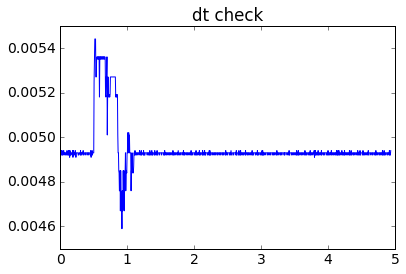

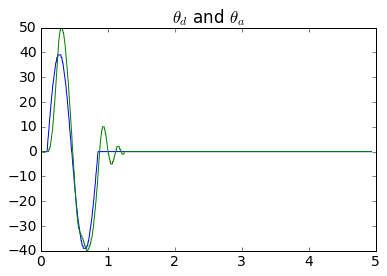

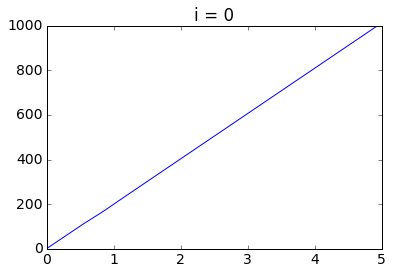

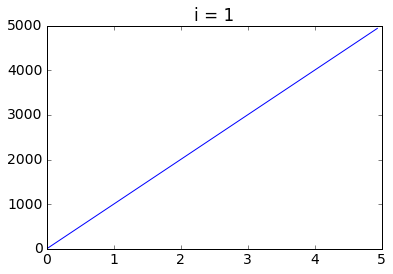

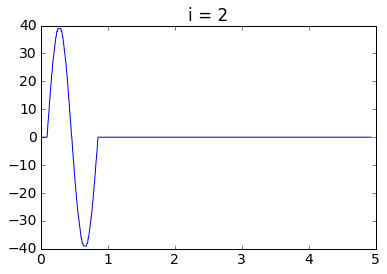

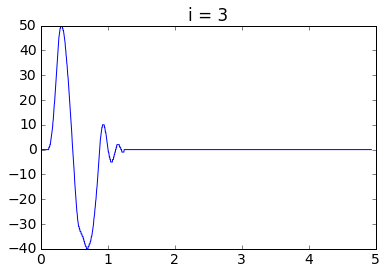

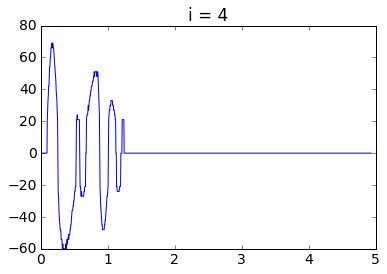

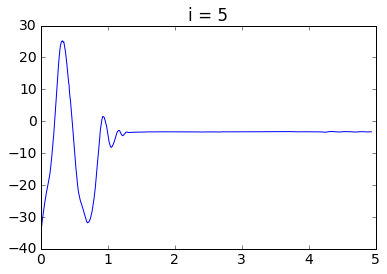

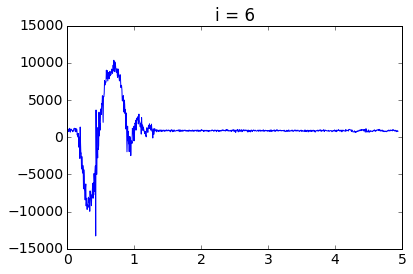

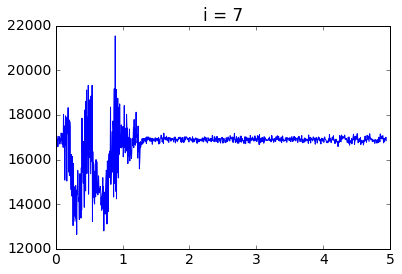

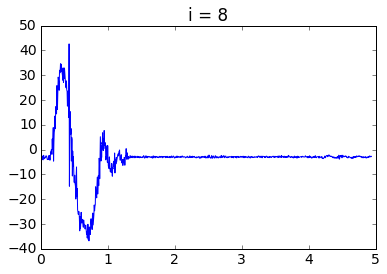

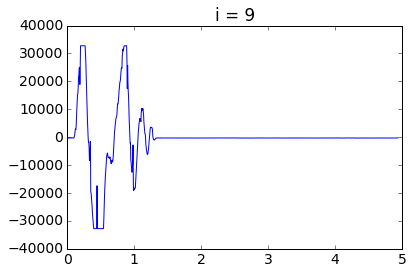

In [425]:
myplotter = data_plotter_6050(data)
myplotter.main()

In [426]:
pat2="test_%0.2i_direct_to_hub_MPU_6050_0_97.csv"

In [427]:
myplotter.save_data(pat2)

'test_02_direct_to_hub_MPU_6050_0_97.csv'